In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from pandas.api.types import CategoricalDtype

from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import matplotlib.dates as mdates

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

import dataStatsAnalysis as dsa
import dataStatsPlotting as dsp

dsp.SetParams()

In [2]:
# Load the hypothesis test superclass
class UnimplementedMethodException(Exception):
    """Exception if someone calls a method that should be overridden."""

class HypothesisTest():
    """Hypothesis test superclass. 
    """

    def __init__(self, data, test_stat=None, tail='right', iters=1000):
        """Initializes the hypothesis test.

        data: data in whatever form is relevant
        """
        self.data = data
        self.tail = tail
        self.iters = iters
        self.test_stat = self.TestStat(test_stat)
        self.rv = self.ComputeRv(data)

#     # Provide the functionality to convert the data into the format needed for use in ComputeRv 
#     # Ex. Convert to array, split data into component groups, etc. 
#     # See child classes for examples
#     def PrepareData(self, data):
#         UnimplementedMethodException()
    
    # Provide the functionality to compute the test stat for the data. 
    # In the case of an alternative hypothesis based test this will need to be supplied via class parameter. 
    # For tests that resample to build a distribution for the null hypothesis 
    # the calculation of the test stat must be provided. 
    # See child classes for examples
    def TestStat(self, test_stat):
        if test_stat != None:
            return test_stat
        else:
            raise Exception('Calculation logic for test_stat not provided in class definition. ' +
                            'If using a null hypothesis based test, this logic must be provided. ' +
                            'If using an alternative hypothesis based test, a test_stat must be provided')
    
    # Provide the functionality that computes the sampling distribution 
    # and the rv for the data. 
    # See child classes for examples
    def ComputeRv(self, data):
        UnimplementedMethodException()
        
#     # Provide the functionality to simulate resampling from the population 
#     # This is needed to implement the Power method.
#     # See child classes for examples
#     def PopulationResample(self):
#         UnimplementedMethodException()
    
    def PValue(self):
        """Computes the distribution of the test statistic and p-value.

        returns: float p-value
        """
        if self.tail == 'left':
            pvalue = self.rv.cdf(self.test_stat)
        elif self.tail == 'right':
            pvalue = 1 - self.rv.cdf(self.test_stat)
        else:
            raise Exception('The value of \'tail\' can only be either \'left\' or \'right\'')

        return pvalue

    def MinMaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return min(self.rv.xk), max(self.rv.xk)

    def PlotCdf(self):
        """Draws a Cdf with a vertical line at the test stat.
        """      
        plt.plot(self.rv.xk, self.rv.cdf(self.rv.xk), color='C0', lw=2) # pylint: disable=no-member
        
        plt.axvline(self.test_stat, color='C1', lw=1.3)

### One-sample mean hypothesis test

In [3]:
class HTMean(HypothesisTest):
    """A one-sample mean hypothesis test. 
    A test_stat to represent the null hypothesis must be provided.
    """  
    def ComputeRv(self, data):       
        # Prepare the data
        data = np.array(data)
        
        # Build the sampling distribution
        mean_estimates = [np.random.choice(data, size=len(data), replace=True).
                          mean() for _ in range(self.iters)]

        return dsa.DiscreteRv(mean_estimates)

    def Power(self, alpha=0.05, num_runs=1000):
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run_data that simulates taking another sample from the population
            run_data = np.random.choice(self.data, size=len(self.data), replace=True)
        
            # Run the hypothesis test with run_data
            test = HTMean(run_data, test_stat=self.test_stat, tail=self.tail)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [4]:
data1 = np.random.randint(17,23,size=100)
data1

array([21, 18, 20, 21, 20, 19, 19, 17, 20, 21, 18, 17, 20, 19, 18, 18, 17,
       17, 19, 22, 22, 21, 18, 21, 17, 18, 20, 18, 21, 21, 20, 20, 20, 22,
       19, 18, 20, 22, 17, 21, 22, 19, 20, 17, 18, 17, 17, 17, 21, 22, 20,
       17, 18, 20, 19, 21, 22, 18, 22, 19, 17, 19, 20, 17, 18, 17, 21, 22,
       20, 22, 18, 18, 19, 18, 22, 17, 17, 20, 17, 21, 21, 22, 22, 22, 18,
       20, 17, 22, 21, 22, 22, 18, 17, 18, 17, 21, 22, 19, 19, 18])

In [5]:
htmean = HTMean(data1, test_stat=19.15, tail='left')

In [6]:
htmean.PValue()

0.098

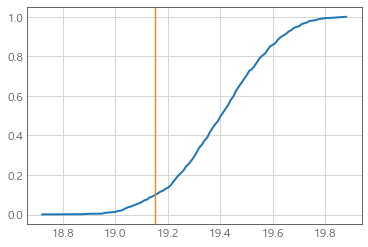

In [7]:
htmean.PlotCdf()

In [8]:
htmean.MinMaxTestStat()

(18.72, 19.88)

In [31]:
# This seems to be working
# But it's significantly slower than my dsa power test
# The results are the same when I use alternative='left' with the dsa power test
# I'm pretty sure this is right since the hypothesis test can only test in one direction
htmean.Power()

0.409

In [36]:
# Compare with my original power test
dsapt = dsa.PTMean(data1, test_stat=19.15, alternative='left')
dsapt.Power()

0.412

In [621]:
data1.mean()

19.41

In [622]:
# Seems to be working, same result as using resample function
results1 = dsa.ResampleMean(data1, iters=1000)
dsa.PvalueFromEstimates(results1, 19.15, tail='left')

0.07

### Diff means hypothesis tests

In [522]:
class HTDiffMeansH0(HypothesisTest):
    """A difference of means hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, onesided=False, tail='right', iters=1000):
        self.onesided = onesided
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        self.a, self.b = data
        self.a = np.array(self.a)
        self.b = np.array(self.b)
        self.pooled_data = np.hstack((self.a, self.b))
        self.a_size = len(self.a)
        
    # For tests that resample to build a distribution for the null hypothesis 
    # the calculation of the test stat must be provided.
    # In the case of a twosided test the absolute value of the difference in means is used
    def TestStat(self):
        if self.onesided == False:
            self.test_stat = abs(self.a.mean() - self.b.mean())
        elif self.onesided == True:
            self.test_stat = self.a.mean() - self.b.mean()
        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
        
    def ComputeRv(self):
        # Build the sampling distribution
        diff_mean_results = []
        
        if self.onesided == False:
            for _ in range(self.iters):
                np.random.shuffle(self.pooled_data)
                group1 = self.pooled_data[:self.a_size]
                group2 = self.pooled_data[self.a_size:]
                result = abs(group1.mean() - group2.mean())
                
                diff_mean_results.append(result)
                    
        elif self.onesided == True:
            for _ in range(self.iters):
                np.random.shuffle(self.pooled_data)
                group1 = self.pooled_data[:self.a_size]
                group2 = self.pooled_data[self.a_size:]
                result = group1.mean() - group2.mean()
                
                diff_mean_results.append(result)
                
        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
            
        self.rv = dsa.DiscreteRv(diff_mean_results)

In [523]:
import first
live, firsts, others = first.MakeFrames()

In [524]:
data2 = [firsts.prglngth.values, others.prglngth.values]

In [525]:
diffmeansHo = HTDiffMeansH0(data2)
diffmeansHo.PValue()

0.16399999999999937

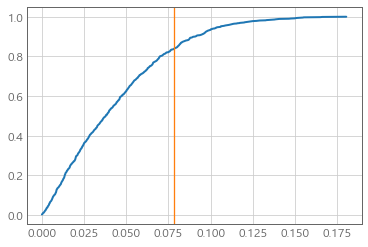

In [526]:
diffmeansHo.PlotCdf()

In [527]:
# Seems to be working, result is the same for new HT test and the resampling function below
# onesided also seems to be working
diffmeansHo_results = dsa.ResampleDiffMeans_H0(data2[0], data2[1])
dsa.PvalueFromEstimates(diffmeansHo_results[1], diffmeansHo_results[0])

0.16399999999999937

In [528]:
class HTDiffMeansHa(HypothesisTest):
    """A difference of means hypothesis test. 
    Uses resampling to build a sampling distrubition that represents the alternative hypothesis.
    """
    # For tests that resample to build a distribution for the alternative hypothesis 
    # a test_stat parameter must be included in __init__ to represent the null hypothesis
    # This test_stat is made an attribute of the class below
    def __init__(self, data, test_stat, tail='right', iters=1000):
        HypothesisTest.__init__(self, data, tail, iters)
        self.test_stat = test_stat

    def PrepareData(self ,data):
        self.a, self.b = data
        self.a = np.array(self.a)
        self.b = np.array(self.b)
        
    def ComputeRv(self):
        # Build the sampling distribution
        diff_mean_results = []
        
        for _ in range(self.iters):
            group1 = np.random.choice(self.a, size=len(self.a), replace=True)
            group2 = np.random.choice(self.b, size=len(self.b), replace=True)
            result = group1.mean() - group2.mean()
                
            diff_mean_results.append(result)
           
        self.rv = dsa.DiscreteRv(diff_mean_results)

In [529]:
diffmeansHa = HTDiffMeansHa(data2, 0, tail='left')
diffmeansHa.PValue()

0.07500000000000005

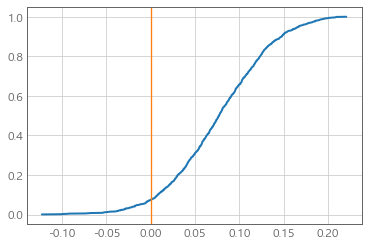

In [530]:
diffmeansHa.PlotCdf()

In [531]:
# It's working.
diffmeansHa_results = dsa.ResampleDiffMeans_Ha(data2[0], data2[1])
dsa.PvalueFromEstimates(diffmeansHa_results[1], 0, tail='left')

0.08400000000000006

### Correlation tests

In [532]:
class HTCorrelationH0(HypothesisTest):
    """A correlation hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, onesided=False, tail='right', iters=1000, method='pearson'):
        self.onesided = onesided
        self.method = method
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        self.x, self.y = data
        self.x = np.array(self.x)
        self.y = np.array(self.y)
        
    # For tests that resample to build a distribution for the null hypothesis 
    # the calculation of the test stat must be provided.
    # In the case of a twosided test the absolute value of the difference in means is used
    def TestStat(self):
        if (self.onesided == False) & (self.method == 'pearson'):
            self.test_stat = abs(stats.pearsonr(self.x , self.y)[0])
        elif (self.onesided == False) & (self.method == 'spearman'):
            self.test_stat = abs(stats.spearmanr(self.x , self.y)[0])
        elif (self.onesided == True) & (self.method == 'pearson'):
            self.test_stat = stats.pearsonr(self.x , self.y)[0]
        elif (self.onesided == True) & (self.method == 'spearman'):
            self.test_stat = stats.spearmanr(self.x , self.y)[0]
        else:
            raise ValueError('\'onesided\' parameter only accepts Boolean True or False, ' +
                             'and \'method\' only accepts \'pearson\' or \'spearman\'')
        
    def ComputeRv(self):
        # Build the sampling distribution
        corrs = []
        
        if (self.onesided == False) & (self.method == 'pearson'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = abs(stats.pearsonr(x_perm , self.y)[0])
                corrs.append(r)
                
        elif (self.onesided == False) & (self.method == 'spearman'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = abs(stats.spearmanr(self.x , self.y)[0])
                corrs.append(r)
        
        elif (self.onesided == True) & (self.method == 'pearson'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = stats.pearsonr(x_perm , self.y)[0]
                corrs.append(r)
                
        elif (self.onesided == True) & (self.method == 'spearman'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = stats.spearmanr(self.x , self.y)[0]
                corrs.append(r)
    
        else:
            raise ValueError('\'onesided\' parameter only accepts Boolean True or False, ' +
                             'and \'method\' only accepts \'pearson\' or \'spearman\'')   
        
        self.rv = dsa.DiscreteRv(corrs)

In [533]:
car = sns.load_dataset('car_crashes')
car.head(3)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ


In [534]:
stats.pearsonr(car.no_previous, car.ins_premium)

(-0.15689520004339752, 0.2715478689798989)

In [604]:
# Seems to be working, variation is: 0.25~0.29 for two-tailed, 0.12~0.15 for one-tailed
data3 = car.no_previous, car.ins_premium
car_hyp = HTCorrelationH0(data3, onesided=True, tail='left', method='pearson')
car_hyp.PValue()

0.1340000000000001

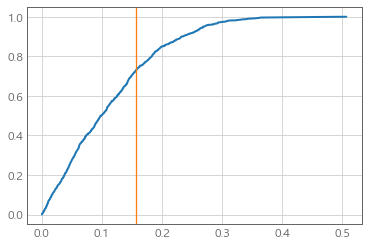

In [536]:
car_hyp.PlotCdf()

In [537]:
class HTCorrelationHa(HypothesisTest):
    """A correlation hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, test_stat, tail='right', iters=1000, method='pearson'):
        self.method = method
        HypothesisTest.__init__(self, data, tail, iters)
        self.test_stat = test_stat

    def PrepareData(self, data):
        self.x, self.y = data
        self.x = np.array(self.x)
        self.y = np.array(self.y)
        self.df = pd.DataFrame({'x':self.x, 'y': self.y})
              
    def ComputeRv(self):
        # Build the sampling distribution
        corrs = []
                
        if self.method == 'pearson':
            for _ in range(self.iters):
                sample = self.df.sample(n=len(self.df), replace=True)
                r = stats.pearsonr(sample.x, sample.y)[0]
                corrs.append(r)
                
        elif self.method == 'spearman':
            for _ in range(self.iters):
                sample = self.df.sample(n=len(self.df), replace=True)
                r = stats.spearmanr(sample.x, sample.y)[0]
                corrs.append(r)
    
        else:
            raise Exception('Must enter either \'pearson\' or \'spearman\ ' +
                            'as a string for the \'method\' argument')   
        
        self.rv = dsa.DiscreteRv(corrs)

In [571]:
# Seems to be working, variation is : 0.16 ~ 0.19
car_hypa = HTCorrelationHa(data3, 0, method='pearson')
car_hypa.PValue()

0.1869999999999994

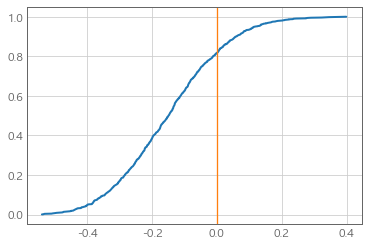

In [539]:
car_hypa.PlotCdf()

In [540]:
# Compare my new function with the old one
# Variation is about .25 ~ .30
# Similar to results from my new hypothesis test
HTcorrperm = dsa.HTCorrelationPermute(data3)
HTcorrperm.PValue()

0.253

### Chi square tests

In [627]:
class HTChiSquare(HypothesisTest):
    """A chi square hypothesis test. 
    Uses resampling of the expected sequence to simulate the null hypothesis 
    and build the null hypothesis sampling distribution. 
    Takes data in the form of two sequences: data = observed, expected.
    """
    def PrepareData(self, data):
        self.observed, self.expected = data
        self.observed = np.array(self.observed)
        self.expected = np.array(self.expected)
        
        # Check that sum of values are equal
        if np.isclose(sum(self.observed), sum(self.expected)) == False:
            raise ValueError('The sum of the values for observed and expected must be equal.')
        
    def TestStat(self):
        self.test_stat = sum((self.observed - self.expected)**2 / self.expected)
        
    def ComputeRv(self):
        # Calculate the variables needed for resampling        
        n = sum(self.expected)
        values = list(range(len(self.expected)))
        p_exp = self.expected/sum(self.expected)
        
        # Build the sampling distribution
        chis = []
        
        for _ in range(self.iters):          
            hist = Counter({x:0 for x in values}) # Initialize a Counter with zero values
            hist.update(np.random.choice(values, size=n, replace=True, p=p_exp))
            sorted_hist = sorted(hist.items())
            model_observed = np.array([x[1] for x in sorted_hist])
            chi = sum((model_observed - self.expected)**2 / self.expected)
                
            chis.append(chi)
            
        self.rv = dsa.DiscreteRv(chis)

In [628]:
observed = [11,7,4,7,12,16,13]
expected = [10,10,10,10,10,10,10]
observed = np.array(observed)
expected = np.array(expected)
data4 = observed, expected

In [729]:
# Getting values of 0.09~0.12, seems to compare well with old class below
htchi = HTChiSquare(data4)
htchi.PValue()

0.10599999999999943

In [658]:
# Compare with my old hypothesis test class (0.09~0.13)
htchi2 = dsa.HTChiSquaredTest(data4)
htchi2.PValue()

0.131

In [733]:
class HTChiSquareContingency(HypothesisTest):
    """A chi square contingency table hypothesis test. 
    Uses resampling of the expected sequence to simulate the null hypothesis 
    and build the null hypothesis sampling distribution. 
    Takes data in the form of a single observed contingency table (array-like).
    """
    def PrepareData(self, data):
        self.observed = data
        self.observed = np.array(self.observed)
        
    # In the case of this class, TestStat also computes self.expected 
    # for later use in the ComputeRv function
    def TestStat(self):
        self.test_stat,_,_,self.expected = stats.chi2_contingency(self.observed)
        
    def ComputeRv(self):
        # Calculate the variables needed for resampling        
        expected_shape = self.expected.shape
        expected_ps = self.expected / np.sum(self.expected)
        values = np.array(list(range(len(self.expected.ravel())))) # Flatten the array and then reshape it later
        n= int(np.sum(self.expected))
        
        # Build the sampling distribution
        chis = []
        
        for _ in range(self.iters):          
            hist = Counter({x:0 for x in values}) # Initiate an empty histogram to hold resampled values
            hist.update(np.random.choice(values, size=n, replace=True, p=expected_ps.ravel()))
            sorted_hist = sorted(hist.items())
            resampled_expected = np.array([x[1] for x in sorted_hist])
            resampled_expected_reshaped = resampled_expected.reshape(expected_shape) # Put back into original shape

            chi = stats.chi2_contingency(resampled_expected_reshaped)[0]                
            chis.append(chi)
            
        self.rv = dsa.DiscreteRv(chis)

In [734]:
observed = [[16,24,8],
            [7,8,17]]

In [824]:
# Getting the same results as using my resampling function below (0.001~0.005)
htchicont = HTChiSquareContingency(observed)
htchicont.PValue()

0.003999999999999226

In [736]:
# Compare with my resampling function
def ResampleChiSquareContingency(observed, iters=1000):
    """Generates a chisquared statistic sampling distribution 
    from a contingency table. 
    Can then make an rv of this distribution to plot cdf and  
    compute a p-value for the actual chi-squared statistic (eg. rv.cdf at actual statistic (test_chi)). 
    Can also use the 'min' and 'max' built-ins to find what the most extreme values are from the simluations.

    Args:
        observed (array-like): observed contingency table
        iters (int, optional): Number of iterations to run when building distribution. Defaults to 1000.

    Returns:
        test_chi: Original actual chi squared value
        chis (array): Sampling distribution for the null hypothesis obtained from resampling
    """
    # Put the data into array form
    observed = np.asarray(observed, dtype=np.float64)
    
    # Calculate the test chi square statistic and the expected array
    test_chi,_,_,expected = stats.chi2_contingency(observed)
    
    # Calculate variables to be used in resampling
    expected = np.asarray(expected, dtype=np.float64)
    expected_shape = expected.shape
    expected_ps = expected / np.sum(expected)
    values = np.array(list(range(len(expected.ravel())))) # Flatten the array and then reshape it later
    n= int(np.sum(expected))
      
    # Compute resampled expected values and compute chi square 
    # to build a sampling distribution that represents the null hypothesis
    chis=[]
    for _ in range(iters):
        hist = Counter({x:0 for x in values}) # Initiate an empty histogram to hold resampled values
        hist.update(np.random.choice(values, size=n, replace=True, p=expected_ps.ravel()))
        sorted_hist = sorted(hist.items())
        resampled_expected = np.array([x[1] for x in sorted_hist])
        resampled_expected_reshaped = resampled_expected.reshape(expected_shape) # Put back into original shape

        chi = stats.chi2_contingency(resampled_expected_reshaped)[0]
        chis.append(chi)

    return test_chi, np.array(chis)

In [810]:
chicont2results = ResampleChiSquareContingency(observed)

In [811]:
# Results are 0.001~0.005
dsa.PvalueFromEstimates(chicont2results[1], chicont2results[0])

0.003999999999999226

In [541]:
# Need to also consider whether or not my original resampling functions should really return a test_stat.
# It doesn't seem like it really is a test_stat in the alternative hypothesis case
# It is actually just the original data statistic
# Is this really needed?